In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scvi.dataset import RetinaDataset
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import scanpy as sc
import anndata
import torch

import pyliger

# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

%matplotlib inline 

# Sets torch and numpy random seeds, run after all scvi imports
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 

In [2]:
def getNClusters(data, n_cluster, range_min=0, range_max=4, max_steps=20, verbose=False):
    if isinstance(data, np.ndarray):
        data = anndata.AnnData(X=data)
    assert isinstance(data, anndata.AnnData), \
        "data must be numpy.ndarray or anndata.AnnData"
    this_min = range_min
    this_max = range_max
    for this_step in range(max_steps):
        if verbose:
            print("step: " + str(this_step))
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.pp.neighbors(data)
        sc.tl.louvain(data, resolution=this_resolution)
        this_clusters = len(np.unique(data.obs['louvain']))
        if verbose:
            print('got ' + str(this_clusters) + ' at resolution ' + str(this_resolution))
        if this_clusters > n_cluster:
            this_max = this_resolution
        if this_clusters < n_cluster:
            this_min = this_resolution
        if this_clusters == n_cluster:
            if not verbose:
                print('got ' + str(this_clusters) + ' at resolution ' + str(this_resolution))
            return data
    print('Cannot find the number of clusters')

In [3]:
from scipy.optimize import linear_sum_assignment
def align(y_true, y_pred, index):
    y_true = pd.Categorical(y_true)
    y_types = y_true.categories.tolist()
    y_label = y_true.codes
    y_label = np.array(y_label) if type(y_label) != np.ndarray else y_label
    y_pred = np.array(y_pred) if type(y_pred) != np.ndarray else y_pred
    y_label = y_label.astype(np.int64)
    D = max(y_pred.max(), y_label.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_label[i]] += 1
    ind = linear_sum_assignment(w.max() - w)[1]
    y_pred = ind[y_pred]
    labels_pred=pd.Series(y_pred, index = index, dtype='category')
    return labels_pred

In [4]:
save_path = "/data/Bear/scVIC/notebooks/Datasets/Biological Datasets"
retina_dataset = RetinaDataset(save_path=save_path)
retina_dataset.filter_genes_by_count(per_batch=True)
retina_dataset.make_gene_names_lower()
retina_dataset.subsample_genes(4000)

[2024-05-07 00:26:33,670] INFO - scvi.dataset.dataset | File /data/Bear/scVIC/notebooks/Datasets/Biological Datasets/retina.loom already downloaded
[2024-05-07 00:26:33,671] INFO - scvi.dataset.loom | Preprocessing dataset
[2024-05-07 00:26:43,075] INFO - scvi.dataset.loom | Finished preprocessing dataset
[2024-05-07 00:26:47,589] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2024-05-07 00:26:47,592] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2024-05-07 00:26:48,053] INFO - scvi.dataset.dataset | Downsampling from 13166 to 13085 genes
[2024-05-07 00:26:51,271] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2024-05-07 00:26:52,528] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2024-05-07 00:26:56,019] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2024-05-07 00:26:56,393] INFO - scvi.dataset.dataset | Downsampled from 19829 to 19829 cells
[2024-05-07 00:26:56,394] INFO - scvi.dataset

In [5]:
batch0_bool = retina_dataset.batch_indices == [0]
cell_names = pd.RangeIndex(start=0, stop=retina_dataset.X.shape[0], step=1).astype(str)
df_retina = pd.DataFrame(retina_dataset.X, index=cell_names, columns=retina_dataset.gene_names)
adata = anndata.AnnData(df_retina)
adata.obs.index.name = 'cell_id'
adata.var.index.name = 'gene_id'
retina_dataset_batch0 = adata[batch0_bool].copy()
retina_dataset_batch1 = adata[~batch0_bool].copy()
retina_dataset_batch0.uns['sample_name'] = 'Batch 0'
retina_dataset_batch1.uns['sample_name'] = 'Batch 1'
adata_list = [retina_dataset_batch0, retina_dataset_batch1]
ifnb_liger = pyliger.create_liger(adata_list)

In [6]:
pyliger.normalize(ifnb_liger)
pyliger.select_genes(ifnb_liger)
pyliger.scale_not_center(ifnb_liger)

In [7]:
pyliger.optimize_ALS(ifnb_liger, k = 20)

100%|██████████| 30/30 [04:14<00:00,  8.49s/it]


In [8]:
pyliger.quantile_norm(ifnb_liger)

In [9]:
H_norm = np.zeros((len(ifnb_liger.adata_list[0]) + len(ifnb_liger.adata_list[1]), 20))

In [10]:
H_norm = np.zeros((len(ifnb_liger.adata_list[0]) + len(ifnb_liger.adata_list[1]), 20))
H_norm[np.where(batch0_bool),:] = ifnb_liger.adata_list[0].obsm['H_norm']
H_norm[np.where(~batch0_bool),:] = ifnb_liger.adata_list[1].obsm['H_norm']

In [11]:
data = getNClusters(H_norm, n_cluster=retina_dataset.n_labels)
labels_pred = data.obs["louvain"].astype(int)

got 15 at resolution 0.515625


In [12]:
post_adata = anndata.AnnData(X=retina_dataset.X)
post_adata.obsm["X_liger"] = H_norm
post_adata.obs['cell_type'] = np.array([retina_dataset.cell_types[retina_dataset.labels[i][0]]  
                                        for i in range(post_adata.n_obs)])
post_adata.obs['batch'] = np.array([str(retina_dataset.batch_indices[i][0])
                                   for i in range(post_adata.n_obs)])
labels_pred=pd.Series(labels_pred, index=post_adata.obs.index, dtype='category')
post_adata.obs['predicted_type'] = labels_pred
sc.pp.neighbors(post_adata, use_rep="X_liger", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.3)
show_plot = True

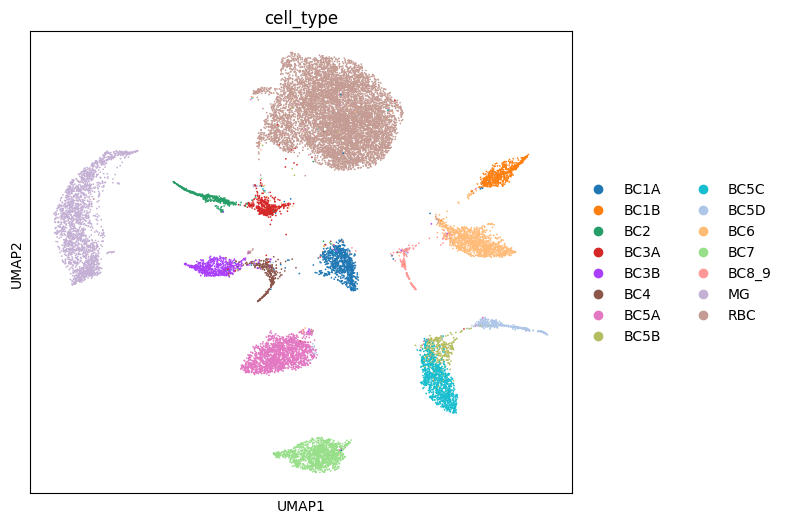

In [13]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["cell_type"], ax=ax, show=show_plot, save="/RETINA_LIGER_Louvain_cell_type.png")

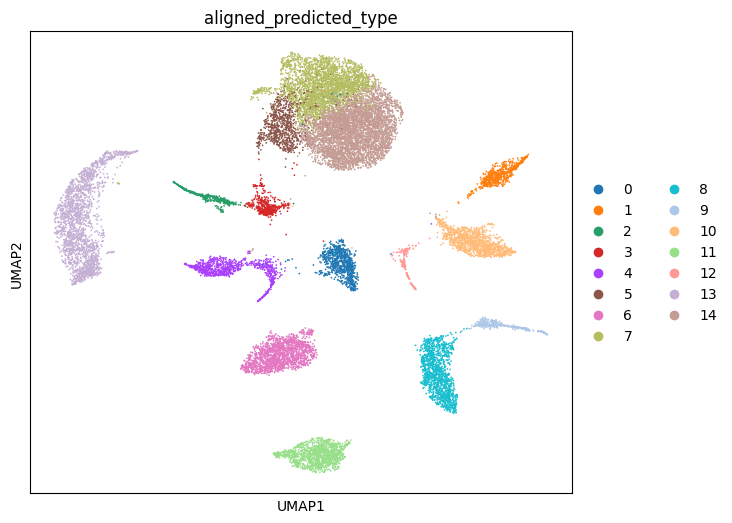

In [14]:
post_adata.obs["aligned_predicted_type"] = align(post_adata.obs["cell_type"], post_adata.obs["predicted_type"], index=post_adata.obs.index)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["aligned_predicted_type"], ax=ax, show=show_plot, save="/RETINA_LIGER_Louvain_predicted_type.png")

In [15]:
ARI = np.around(adjusted_rand_score(retina_dataset.labels.squeeze(), labels_pred), 5)
print("RETINA_LIGER_Louvain_ARI: ")
print(ARI)
NMI = np.around(normalized_mutual_info_score(retina_dataset.labels.squeeze(), labels_pred, average_method='arithmetic'), 5)
print("RETINA_LIGER_Louvain_NMI: ")
print(NMI)  

RETINA_LIGER_Louvain_ARI: 
0.61911
RETINA_LIGER_Louvain_NMI: 
0.85327


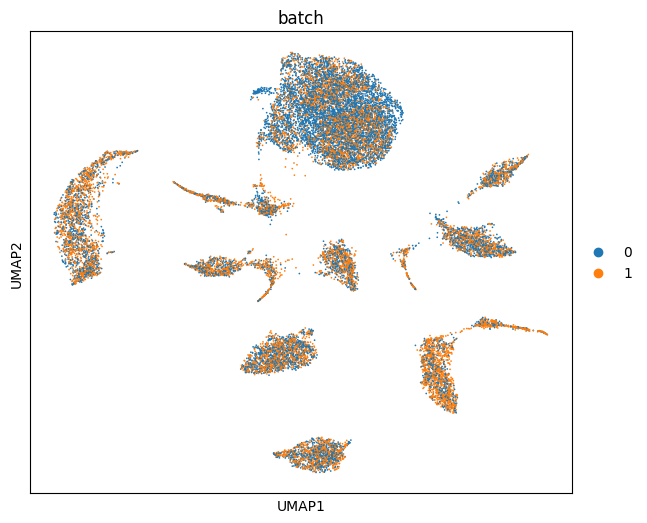

In [16]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["batch"], ax=ax, show=show_plot, save="/RETINA_LIGER_Louvain_batch.png")

In [17]:
from scvic.utils import entropy_batch_mixing
entropy_batch_mixing = np.around(entropy_batch_mixing(H_norm, retina_dataset.batch_indices, retina_dataset.n_batches), 5)
print("RETINA_LIGER_batch_mixing: ") 
print(entropy_batch_mixing)

RETINA_LIGER_batch_mixing: 
0.04691
